In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

from pylab import rcParams

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)

VITALS = ['LABEL_RRate', 'LABEL_ABPm', 'LABEL_SpO2', 'LABEL_Heartrate']
TESTS = ['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total',
         'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2',
         'LABEL_Bilirubin_direct', 'LABEL_EtCO2']

VARIABLES = ['BaseExcess', 'Fibrinogen', 'AST', 'Alkalinephos', 'Bilirubin_total', 'Lactate', 'TroponinI', 'SaO2','Bilirubin_direct', 'EtCO2', 'Temp', 'RRate', 'FiO2', 'Glucose', 'ABPm', 'Potassium', 'ABPd', 'SpO2', 'Hct', 'Heartrate', 'ABPs', 'pH']

FEAT_DESCS = []

In [3]:
def get_patient_data(X, pids):
    return X.loc[X['pid'].isin(pids)]

def impute_variable(X_pid, var, strategy, stats):
    '''imputes time series of variable var according to given imputation strategy
    '''
    if X_pid[var].count == 0:
        return np.full((12,), stats[var].median())
    else:
        if strategy == 'linear_interpolation':
            return X_pid[var].interpolate().to_numpy()
    return []

In [4]:
train_df = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
test_df = pd.read_csv('test_features.csv')

all_pids = train_df['pid'].unique()
train_pids, val_pids = train_test_split(all_pids, random_state=42)

In [5]:
train_df.head()

,pid,Time,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
0,1,3,34.0,NaN,NaN,12.0,NaN,36.0,8.7,24.0,-2.0,16.0,NaN,NaN,6.3,NaN,45.0,NaN,NaN,NaN,NaN,NaN,84.0,1.2,3.8,61.0,NaN,NaN,100.0,NaN,114.0,24.6,94.0,NaN,NaN,142.0,7.33
1,1,4,34.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,-2.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,81.0,NaN,NaN,62.5,NaN,NaN,100.0,NaN,NaN,NaN,99.0,NaN,NaN,125.0,7.33
2,1,5,34.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,0.0,18.0,NaN,NaN,NaN,NaN,43.0,NaN,0.4,NaN,NaN,NaN,74.0,NaN,NaN,59.0,NaN,NaN,100.0,NaN,NaN,NaN,92.0,NaN,NaN,110.0,7.37
3,1,6,34.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,0.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,NaN,NaN,49.5,NaN,NaN,100.0,NaN,NaN,NaN,88.0,NaN,NaN,104.0,7.37
4,1,7,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,1.8,NaN,48.0,NaN,NaN,100.0,NaN,NaN,22.4,81.0,NaN,NaN,100.0,7.41


In [6]:
get_patient_data(train_df, [10000])

,pid,Time,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
48,10000,1,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,10000,2,76.0,NaN,25.7,NaN,NaN,36.0,11.0,25.0,0.0,11.0,NaN,NaN,7.5,1.0,48.0,NaN,0.6,139.0,98.0,137.5,68.0,1.4,4.1,49.5,NaN,NaN,100.0,NaN,104.0,31.3,64.0,NaN,NaN,110.0,7.35
50,10000,3,76.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,NaN,NaN,43.0,NaN,NaN,100.0,NaN,NaN,NaN,66.0,NaN,NaN,95.0,NaN
51,10000,4,76.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,3.0,12.0,NaN,NaN,NaN,NaN,42.0,NaN,0.4,NaN,99.0,NaN,81.0,NaN,NaN,56.0,NaN,NaN,100.0,NaN,NaN,NaN,75.0,NaN,NaN,135.0,7.42
52,10000,5,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,13.0,NaN,NaN,NaN,NaN,44.0,NaN,0.5,NaN,98.0,NaN,68.0,NaN,NaN,47.5,NaN,NaN,98.0,NaN,NaN,NaN,77.0,NaN,NaN,117.0,7.39
53,10000,6,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,12.0,NaN,NaN,NaN,NaN,44.0,NaN,0.5,NaN,98.0,NaN,73.0,NaN,NaN,51.0,NaN,NaN,97.0,NaN,NaN,NaN,79.0,NaN,NaN,130.0,7.40
54,10000,7,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,NaN,NaN,51.0,NaN,NaN,99.0,NaN,NaN,NaN,75.0,NaN,NaN,132.0,NaN
55,10000,8,76.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,51.0,NaN,NaN,38.0,NaN,NaN,98.0,NaN,NaN,NaN,69.0,NaN,NaN,98.0,NaN
56,10000,9,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,NaN,NaN,47.0,NaN,NaN,98.0,NaN,NaN,NaN,73.0,NaN,NaN,111.0,NaN
57,10000,10,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,NaN,NaN,51.0,NaN,NaN,98.0,NaN,NaN,NaN,90.0,NaN,NaN,152.0,NaN


In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227940 entries, 0 to 227939
Data columns (total 37 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   pid               227940 non-null  int64  
 1   Time              227940 non-null  int64  
 2   Age               227940 non-null  float64
 3   EtCO2             9783 non-null    float64
 4   PTT               10299 non-null   float64
 5   BUN               20105 non-null   float64
 6   Lactate           10756 non-null   float64
 7   Temp              81115 non-null   float64
 8   Hgb               22295 non-null   float64
 9   HCO3              12559 non-null   float64
 10  BaseExcess        19887 non-null   float64
 11  RRate             187785 non-null  float64
 12  Fibrinogen        2493 non-null    float64
 13  Phosphate         11590 non-null   float64
 14  WBC               19083 non-null   float64
 15  Creatinine        17792 non-null   float64
 16  PaCO2             21

In [8]:
missing = (train_df.isnull().sum() / train_df.shape[0])*100
missing

pid                  0.000000
Time                 0.000000
Age                  0.000000
EtCO2               95.708081
PTT                 95.481706
BUN                 91.179696
Lactate             95.281214
Temp                64.413881
Hgb                 90.218917
HCO3                94.490217
BaseExcess          91.275336
RRate               17.616478
Fibrinogen          98.906291
Phosphate           94.915329
WBC                 91.628060
Creatinine          92.194437
PaCO2               90.768185
AST                 97.472581
FiO2                88.329385
Platelets           92.087830
SaO2                94.290603
Glucose             79.364745
ABPm                14.061156
Magnesium           92.312451
Potassium           87.543652
ABPd                33.132403
Calcium             92.177766
Alkalinephos        97.495832
SpO2                14.366939
Bilirubin_direct    99.684566
Chloride            93.894446
Hct                 88.024480
Heartrate           12.201457
Bilirubin_

Text(0.5, 1.0, 'Percentage of missing data in each feature')

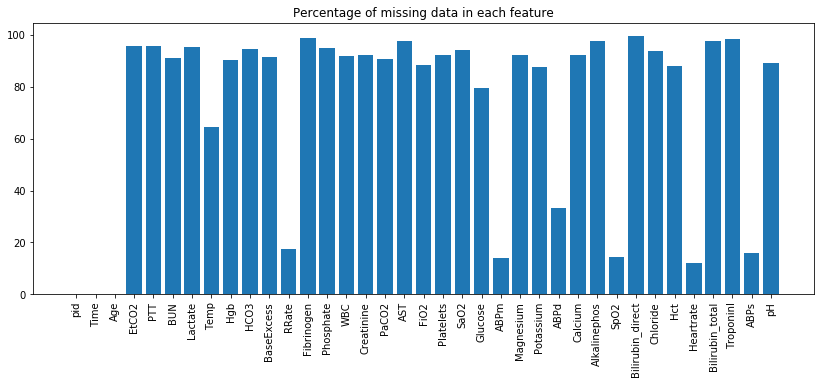

In [13]:
rcParams['figure.figsize'] = 14, 5
plt.bar(missing.index, missing)
plt.xticks(missing.index, rotation=90)

plt.title("Percentage of missing data in each feature")

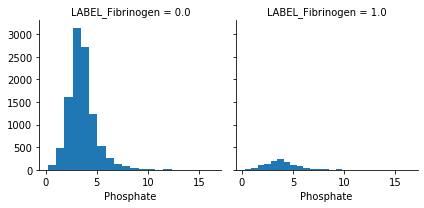

In [57]:
g = sns.FacetGrid(pd.merge(train_df, train_labels, on='pid'), col='LABEL_Fibrinogen')
g.map(plt.hist, 'Phosphate', bins=20)

In [83]:
features = train_df.groupby('pid').median().fillna(0)
features

,Time,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
pid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,8.5,34.0,0.0,0.0,12.0,0.0,37.0,8.50,26.0,0.0,18.0,0.0,4.60,4.7,0.500,43.0,0.0,0.4,143.0,0.0,120.0,67.5,1.80,4.1,48.5,7.6,0.0,100.0,0.0,111.0,23.10,75.0,0.0,0.00,111.0,7.370
2,6.5,86.0,0.0,31.8,32.0,0.0,36.0,13.10,0.0,0.0,19.0,0.0,3.80,9.3,2.120,0.0,0.0,0.0,226.0,0.0,111.0,95.0,2.10,3.8,72.0,9.5,0.0,96.0,0.0,0.0,40.20,59.0,0.0,0.44,129.0,0.000
4,6.5,66.0,0.0,34.6,8.0,0.0,37.0,10.55,0.0,0.0,14.0,0.0,3.10,7.5,0.530,0.0,34.0,0.0,269.0,0.0,102.0,74.0,2.45,3.5,49.0,8.2,130.0,100.0,0.1,0.0,33.55,72.0,0.6,0.02,124.0,0.000
6,7.5,66.0,0.0,53.8,32.0,1.8,38.0,10.60,19.5,-3.0,13.5,0.0,3.10,39.7,1.350,39.0,0.0,0.5,105.0,98.0,128.0,66.5,3.10,4.7,49.5,7.8,0.0,100.0,0.0,113.5,30.45,88.0,0.0,0.00,99.0,7.350
8,6.5,42.0,0.0,0.0,18.0,0.0,36.0,0.00,0.0,0.0,18.0,0.0,3.30,0.0,6.460,0.0,0.0,0.0,0.0,0.0,118.0,143.5,2.10,4.3,107.5,7.9,0.0,98.0,0.0,0.0,0.00,81.0,0.0,0.08,209.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31653,6.5,52.0,0.0,25.8,11.0,1.7,36.0,9.10,23.0,0.0,14.0,633.0,4.40,11.6,0.700,49.0,0.0,0.0,489.0,0.0,137.0,63.0,2.40,4.9,49.0,7.9,0.0,96.0,0.0,106.0,32.90,102.0,0.0,0.00,87.0,7.330
31654,6.5,66.0,0.0,0.0,33.0,0.0,37.5,11.20,0.0,0.0,17.0,0.0,5.45,2.0,10.335,0.0,0.0,0.0,124.0,0.0,87.5,123.0,2.10,5.7,97.0,8.5,0.0,96.0,0.0,0.0,34.60,90.0,0.0,0.00,163.0,0.000
31656,6.5,44.0,0.0,0.0,15.0,0.0,38.0,12.40,24.0,-3.5,25.0,0.0,0.00,24.0,0.700,44.5,0.0,0.4,345.0,0.0,115.0,77.5,0.00,4.0,61.5,0.0,0.0,100.0,0.0,97.0,36.70,97.5,0.0,0.00,98.0,7.305


In [85]:
target = get_patient_data(train_labels, train_pids)[['pid', 'LABEL_BaseExcess']]
target = target.sort_values(by='pid').drop('pid', axis=1).to_numpy().ravel()

features = get_patient_data(train_df, train_pids)
features = scale(features.sort_index())

feature_importance_estimator = LinearSVC(C=0.02, penalty="l1", dual=False).fit(features, target)
svm_model = SelectFromModel(linear_estimator_feature_importance, prefit = True)
relevant_features = svm_model.transform(features)

print ('Basis of learning hyperspace has', relevant_features.shape[1], 'dimensions.')
print ('The reduction in use of features was', (relevant_features.shape[1]/features.shape[1])*100, '%.')
print ('From', features.shape[1], 'to', relevant_features.shape[1], 'features.')

KeyError: 'pid'

In [59]:
X_all = []

for pid in train_pids:
    X_pid = train_df.loc[train_df['pid'] == pid]

    imputed_time_series={}
    imp_strategy = 'linear_interpolation'
    for var in VARIABLES:
        imputed_time_series[var, imp_strategy] = impute_variable(X_pid, var, imp_strategy, train_stats)

    feat_row = []
    for feat_desc in FEAT_DESCS:
        needed_inputs, fun = feat_desc
        args = []
        for var, needs_imputed, strategy in needed_inputs:
            if needs_inputed:
                arg = imputed_time_series[var, strategy]
            else:
                arg = X_pid[var].to_numpy()
            args.append(arg)
        
        feature = fun(args)
        feat_row.append(feature)
    
    X_all.append(feat_row)

X_train = np.concatenate(X_all, axis=0)